# Block Model with a 1D background -- Comparison

### For the model, see the notebook BlockModel.ipynb

We'll have to add detail information about

- How many cells
- How many threads
- CPU
- RAM
- On what type of machine run

We should do that in detail at the end. Here some preliminary info from your comments:

(emg3d took quite long (but on one thread), as I discretized it very finely, which can be seen in the rather precise 1D result. I might coarsen it later on, to get faster speed at the cost of precision, to be in a similar ballpark.)

### emg3d
- 4,718,592 cells
- 13 minutes
- 1 thread
- ~ 1 GB RAM
- My Laptop

### custEM
- ?? cells
- 90 s
- 32 cores/threads
- ?? RAM
- Server?

### PETGEM
- ?? cells
- 120 s
- 24 cores/threads
- ?? RAM
- Server


In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
plt.style.use('ggplot')

## Load data

In [3]:
def extract_lines(name):
    inp = xr.load_dataset(name, engine='h5netcdf')
    print_attributes(inp)
    return np.stack([inp.line_1_re+1j*inp.line_1_im,
                     inp.line_2_re+1j*inp.line_2_im,
                     inp.line_3_re+1j*inp.line_3_im]).T


def print_attributes(inp):
    for key in ['runtime', 'cputime', 'nthreads', 'maxram',
                'ncells', 'nnodes', 'ndof', 'extent',
                'min_cwidth', 'max_cwidth', 'machine',
                'version', 'date']:
        print(f"{key:10} : {inp.attrs[key]}")

In [4]:
ds = xr.load_dataset('block_model_and_survey.nc', engine='h5netcdf')
rec_x = ds.x
rec_y = ds.attrs['rec_y']

### Semi-analytical background result from `empymod`

In [5]:
epm_1d = extract_lines('results/layered_empymod.nc')

runtime    : <1 s
cputime    : <1 s
nthreads   : 1
maxram     : 0 MiB
ncells     : N/A
nnodes     : N/A
ndof       : N/A
extent     : N/A
min_cwidth : N/A
max_cwidth : N/A
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 16 GB of memory, Ubuntu 18.04
version    : 1.10.6
date       : 2020-03-18T15:30:46.411092


### `emg3d`

In [6]:
# BACKGROUND
egd_bg = extract_lines('results/layered_emg3d.nc')
print(f"\n= - = - =  :  {14*'= - '}=\n")
# 3D
egd_tg = extract_lines('results/block_emg3d.nc')

runtime    : 122 s
cputime    : 122 s
nthreads   : 1
maxram     : 349 MiB
ncells     : (256 x 64 x 96) - 1572864
nnodes     : N/A
ndof       : N/A
extent     : x = -57087.8-65201.2; y = -51967.8-51967.8; z = -35514.7-65482.0
min_cwidth : (100.0 x 200.0 x 50.0)
max_cwidth : (8113.4 x 14623.9 x 19403.1)
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 16 GB of memory, Ubuntu 18.04
version    : 0.9.3
date       : 2020-03-18T16:34:56.262955

= - = - =  :  = - = - = - = - = - = - = - = - = - = - = - = - = - = - =

runtime    : 98 s
cputime    : 98 s
nthreads   : 1
maxram     : 676 MiB
ncells     : (128 x 128 x 64) - 1048576
nnodes     : N/A
ndof       : N/A
extent     : x = -106580.7-106580.7; y = -109379.1-109379.1; z = -35828.4-119288.6
min_cwidth : (100.0 x 100.0 x 100.0)
max_cwidth : (26001.1 x 21175.8 x 32947.6)
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 16 GB of memory, Ubuntu 18.04
version    : 0.9.3
date       : 2020-03-18T15:29:16.510462


### `PETGEM`

In [7]:
# BACKGROUND
ptg0 = np.load('results/PETGEM_old/y_0_E_bm_p2.npy')
# ptgp = np.load('results/PETGEM_old/y_3000_E_bm.npy')
ptgm = np.load('results/PETGEM_old/y_-3000_E_bm_p2.npy')
ptg_bg = np.vstack([ptgm[:, 0], ptg0[:, 0], ptgm[:, 0]]).T
# Take conjugate, PETGEM uses -iwt, as oposed to emg3d/custEM which have iwt.
ptg_bg = ptg_bg.conj()

# 3D
ptg0 = np.load('results/PETGEM_old/y_0_E_le_p2.npy')
ptgp = np.load('results/PETGEM_old/y_3000_E_le_p2.npy')
ptgm = np.load('results/PETGEM_old/y_-3000_E_le_p2.npy')
ptg = np.vstack([ptgm[:, 0], ptg0[:, 0], ptgp[:, 0]]).T
# Take conjugate, PETGEM uses -iwt, as oposed to emg3d/custEM which have iwt.
ptg = ptg.conj()

### `custEM`

In [8]:
# BACKGROUND
cst0 = np.load('results/custEM_old/y_0_E_le_p2.npy')
# cstp = np.load('results/custEM_old/y_3000_E_le.npy')
cstm = np.load('results/custEM_old/y_-3000_E_le_p2.npy')
cst_bg = np.vstack([cstm[:, 0], cst0[:, 0], cstm[:, 0]]).T #, cstp[:, 0]]).T

# 3D
cst0 = np.load('results/custEM_old/y_0_E_bm_p2.npy')
cstp = np.load('results/custEM_old/y_3000_E_bm_p2.npy')
cstm = np.load('results/custEM_old/y_-3000_E_bm_p2.npy')
cst = np.vstack([cstm[:, 0], cst0[:, 0], cstp[:, 0]]).T

## Compare 1D background

In [9]:
# Calculate error
egd_rerr = np.clip(100*abs((epm_1d.real-egd_bg.real)/epm_1d.real), 0.01, 100)
cst_rerr = np.clip(100*abs((epm_1d.real-cst_bg.real)/epm_1d.real), 0.01, 100)
ptg_rerr = np.clip(100*abs((epm_1d.real-ptg_bg.real)/epm_1d.real), 0.01, 100)
egd_ierr = np.clip(100*abs((epm_1d.imag-egd_bg.imag)/epm_1d.imag), 0.01, 100)
cst_ierr = np.clip(100*abs((epm_1d.imag-cst_bg.imag)/epm_1d.imag), 0.01, 100)
ptg_ierr = np.clip(100*abs((epm_1d.imag-ptg_bg.imag)/epm_1d.imag), 0.01, 100)

<IPython.core.display.Javascript object>


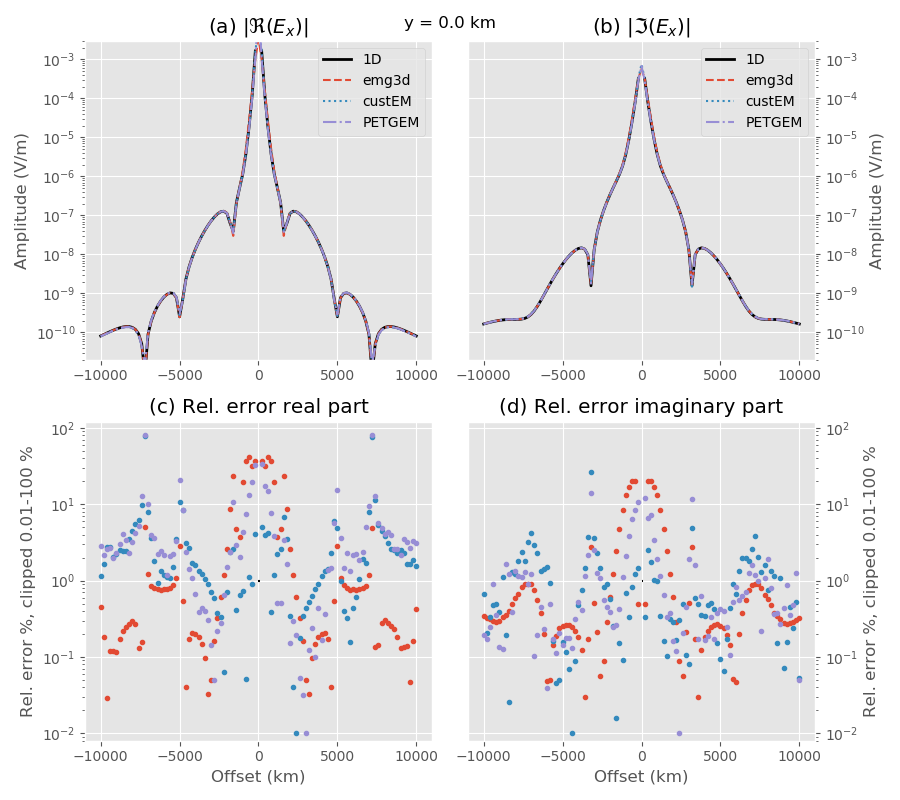

In [10]:
plt.figure(figsize=(9, 8))
plt.suptitle(f'y = {rec_y[1]/1e3} km')
# Real
ax1 = plt.subplot(221)
plt.title(r'(a) $|\Re(E_x)|$')
plt.plot(rec_x, abs(epm_1d[:, 1].real), f'k-', lw=2, label=f'1D')
plt.plot(rec_x, abs(egd_bg[:, 1].real), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst_bg[:, 1].real), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg_bg[:, 1].real), f'C2-.', label=f'PETGEM')

plt.yscale('log')
plt.legend()
plt.ylabel('Amplitude (V/m)')

# Imaginary
ax2 = plt.subplot(222, sharey=ax1)
plt.title(r'(b) $|\Im(E_x)|$')

plt.plot(rec_x, abs(epm_1d[:, 1].imag), f'k-', lw=2, label=f'1D')
plt.plot(rec_x, abs(egd_bg[:, 1].imag), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst_bg[:, 1].imag), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg_bg[:, 1].imag), f'C2-.', label=f'PETGEM')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

# Real
ax3 = plt.subplot(223)
plt.title('(c) Rel. error real part')

plt.plot(rec_x, egd_rerr[:, 1], 'C0.')
plt.plot(rec_x, cst_rerr[:, 1], 'C1.')
plt.plot(rec_x, ptg_rerr[:, 1], 'C2.')
plt.yscale('log')
plt.hlines(1, 0, 100)
plt.xlabel('Offset (km)')
plt.ylabel('Rel. error %, clipped 0.01-100 %')
plt.ylim([0.008, 120])

# Imaginary
ax4 = plt.subplot(224, sharey=ax3)
plt.title('(d) Rel. error imaginary part')

plt.plot(rec_x, egd_ierr[:, 1], 'C0.')
plt.plot(rec_x, cst_ierr[:, 1], 'C1.')
plt.plot(rec_x, ptg_ierr[:, 1], 'C2.')
plt.yscale('log')
plt.hlines(1, 0, 100)
plt.xlabel('Offset (km)')
plt.ylabel('Rel. error %, clipped 0.01-100 %')
plt.ylim([0.008, 120])

ax4.yaxis.set_ticks_position('right')
ax4.yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


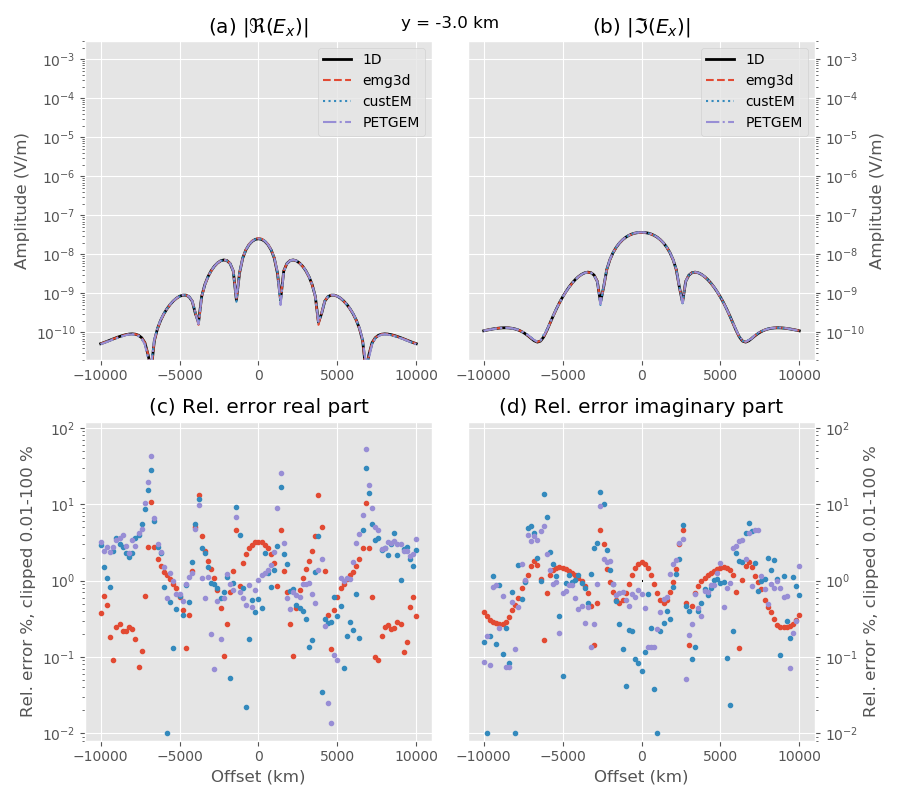

In [11]:
plt.figure(figsize=(9, 8))
plt.suptitle(f'y = {rec_y[0]/1e3} km')
# Real
ax1 = plt.subplot(221)
plt.title(r'(a) $|\Re(E_x)|$')
plt.plot(rec_x, abs(epm_1d[:, 0].real), f'k-', lw=2, label=f'1D')
plt.plot(rec_x, abs(egd_bg[:, 0].real), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst_bg[:, 0].real), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg_bg[:, 0].real), f'C2-.', label=f'PETGEM')

plt.yscale('log')
plt.legend()
plt.ylabel('Amplitude (V/m)')

# Imaginary
ax2 = plt.subplot(222, sharey=ax1)
plt.title(r'(b) $|\Im(E_x)|$')

plt.plot(rec_x, abs(epm_1d[:, 0].imag), f'k-', lw=2, label=f'1D')
plt.plot(rec_x, abs(egd_bg[:, 0].imag), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst_bg[:, 0].imag), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg_bg[:, 0].imag), f'C2-.', label=f'PETGEM')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

# Real
ax3 = plt.subplot(223)
plt.title('(c) Rel. error real part')

plt.plot(rec_x, egd_rerr[:, 0], 'C0.')
plt.plot(rec_x, cst_rerr[:, 0], 'C1.')
plt.plot(rec_x, ptg_rerr[:, 0], 'C2.')

plt.yscale('log')
plt.hlines(1, 0, 100)
plt.xlabel('Offset (km)')
plt.ylabel('Rel. error %, clipped 0.01-100 %')
plt.ylim([0.008, 120])

# Imaginary
ax4 = plt.subplot(224, sharey=ax3)
plt.title('(d) Rel. error imaginary part')

plt.plot(rec_x, egd_ierr[:, 0], 'C0.')
plt.plot(rec_x, cst_ierr[:, 0], 'C1.')
plt.plot(rec_x, ptg_ierr[:, 0], 'C2.')
plt.yscale('log')
plt.hlines(1, 0, 100)
plt.xlabel('Offset (km)')
plt.ylabel('Rel. error %, clipped 0.01-100 %')
plt.ylim([0.008, 120])

ax4.yaxis.set_ticks_position('right')
ax4.yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

## Compare 3D model

<IPython.core.display.Javascript object>


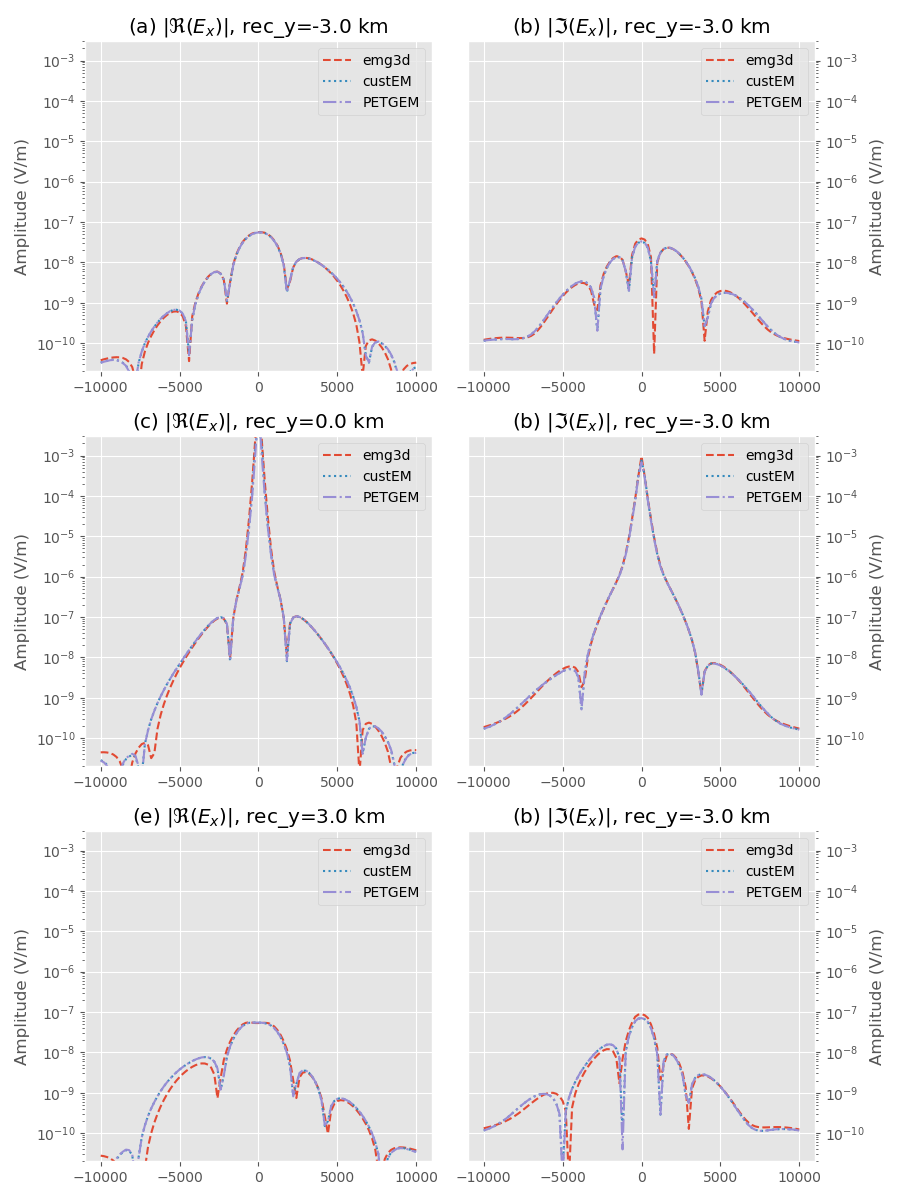

In [12]:
plt.figure(figsize=(9, 12))

# Real
ax1 = plt.subplot(321)
plt.title(f'(a) $|\Re(E_x)|$, rec_y={rec_y[0]/1e3} km')
plt.plot(rec_x, abs(egd_tg[:, 0].real), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst[:, 0].real), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg[:, 0].real), f'C2-.', label=f'PETGEM')
plt.yscale('log')
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax3 = plt.subplot(323, sharey=ax1)
plt.title(f'(c) $|\Re(E_x)|$, rec_y={rec_y[1]/1e3} km')
plt.plot(rec_x, abs(egd_tg[:, 1].real), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst[:, 1].real), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg[:, 1].real), f'C2-.', label=f'PETGEM')
plt.yscale('log')
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax5 = plt.subplot(325, sharey=ax1)
plt.title(f'(e) $|\Re(E_x)|$, rec_y={rec_y[2]/1e3} km')
plt.plot(rec_x, abs(egd_tg[:, 2].real), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst[:, 2].real), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg[:, 2].real), f'C2-.', label=f'PETGEM')
plt.yscale('log')
plt.legend()
plt.ylabel('Amplitude (V/m)')


# Imaginary
ax2 = plt.subplot(322, sharey=ax1)
plt.title(f'(b) $|\Im(E_x)|$, rec_y={rec_y[0]/1e3} km')

plt.plot(rec_x, abs(egd_tg[:, 0].imag), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst[:, 0].imag), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg[:, 0].imag), f'C2-.', label=f'PETGEM')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

ax4 = plt.subplot(324, sharey=ax1)
plt.title(f'(b) $|\Im(E_x)|$, rec_y={rec_y[0]/1e3} km')

plt.plot(rec_x, abs(egd_tg[:, 1].imag), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst[:, 1].imag), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg[:, 1].imag), f'C2-.', label=f'PETGEM')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax4.yaxis.set_ticks_position('right')
ax4.yaxis.set_label_position('right')

ax6 = plt.subplot(326, sharey=ax1)
plt.title(f'(b) $|\Im(E_x)|$, rec_y={rec_y[0]/1e3} km')

plt.plot(rec_x, abs(egd_tg[:, 2].imag), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst[:, 2].imag), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg[:, 2].imag), f'C2-.', label=f'PETGEM')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax6.yaxis.set_ticks_position('right')
ax6.yaxis.set_label_position('right')

plt.tight_layout()
plt.show()